# Costa Rican Household Poverty Level Prediction
## Arnaud Fournier and Tristan Mayer 

#### Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.
#### In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need. While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.
#### The problem we are going to try solving is improving the PMT by building another model based on the analysis of households characteristics. We will implement the different machine learning algorithms we have learned and select the best model according to cross validation performance.

In this notebook, we will walk through a complete machine learning solution: first perform a thorough Exploratory Data Analysis of the dataset, then work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions.


### Problem and Data Explanation
The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

### Objective
The objective is to predict poverty on a HOUSEHOLD level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we will have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

The Target values represent poverty levels as follows:

1 = extreme poverty

2 = moderate poverty 

3 = vulnerable households 

4 = non vulnerable households


### Metric
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by Cross Validation Accuracy.


### EDA
For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures).

In [1]:
# Data manipulation
import pandas as pd
import numpy as np


In [2]:
# Read in data
train = pd.read_csv('/Users/tristanmayer/Desktop/train.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or ordinal variables with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

In [4]:
# Let's have a look at the distribution of unique values in the integer columns (how many colums have n distinct values)
train.select_dtypes(np.int64).nunique().value_counts().sort_index() 

1       1
2     101
4       2
6       2
7       3
9       3
10      3
11      3
13      5
14      1
22      3
97      3
dtype: int64

There are 101 columns with only 2 unique values. It is very likely that those columns are filled with Booleans (0 or 1) and actually corresponds to the decomposition of categorical variables. For example, the columns sanitario1 to sanitario6 corresponds to the type of connection  the toilets (whether it is connected to sewer or cesspool, septic tank, black hole or letrine ...)

We can also notice that there is one columns that takes only one value, it will be useless for our analysis.

In [5]:
train.select_dtypes(np.int64).nunique().loc[lambda x : x==1]
train['elimbasu5'].isna().sum()

0

So the columns 'elimbasu5' which corresponds to '=1 if rubbish disposal mainly by throwing in river,  creek or sea" has only one unique value (0) for all individuals. It is therefore useless for our analysis.

In [6]:
train.drop('elimbasu5', axis=1, inplace=True)

In [7]:
# Now let's have a look at the 'objects' columns:
train.select_dtypes('object').head()


,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Id and idhogar are the way to identify the individuals and the households.
The three other columns are 

dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

For these three variables, "yes" = 1 and "no" = 0 so we are going to replace thos values in the dataframe

In [8]:
train['dependency'] = train['dependency'].replace({"yes": 1, "no": 0}).astype(np.float64)
train['edjefe'] = train['edjefe'].replace({"yes": 1, "no": 0}).astype(np.float64)
train['edjefa'] = train['edjefa'].replace({"yes": 1, "no": 0}).astype(np.float64)


### Data Vizualisation

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Target variable distribution

Text(0.5, 1.0, 'Household Poverty Levels')

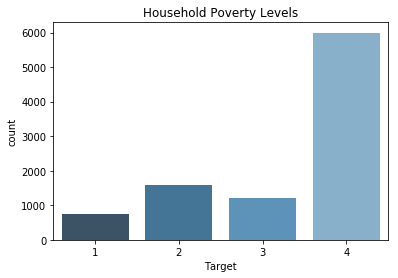

In [31]:
sns.countplot(x="Target", data=train, palette="Blues_d").set_title('Household Poverty Levels')

#### What do households own?

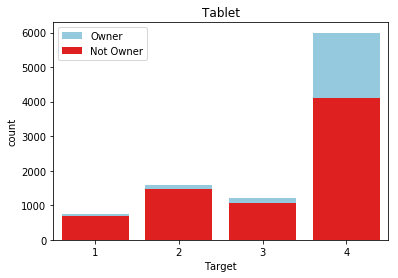

In [146]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['v18q']==0] , color="red", label="Not Owner").set_title('Tablet')
plt.legend()

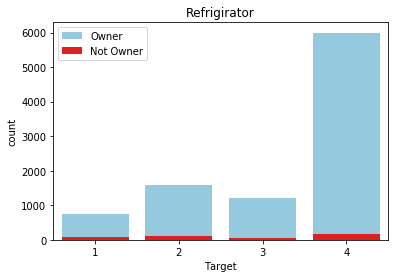

In [140]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['refrig']==0] , color="red",label="Not Owner").set_title('Refrigirator')
plt.legend()

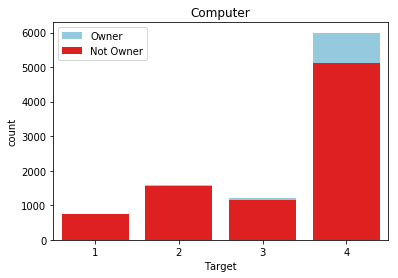

In [141]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['computer']==0] , color="red", label="Not Owner").set_title('Computer')
plt.legend()

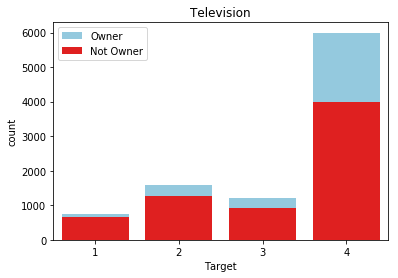

In [142]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['television']==0] , color="red", label="Not Owner").set_title('Television')
plt.legend()

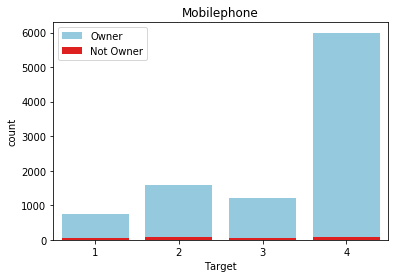

In [143]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['mobilephone']==0] , color="red",label="Not Owner").set_title('Mobilephone')
plt.legend()

#### Key Characteristics of the Households

In [176]:
# Outside Wall Material
df1 = train[['Target', 'paredblolad', 'paredpreb', 'paredmad', 'paredzocalo', 'pareddes', 'paredfibras', 'paredother', 'paredzinc']]
df1.columns = ['Target',"Block / Brick", "Cement", "Wood","Socket", "Waste Material","Fibres", "Other", "Zink"]
df1 = df1.groupby('Target').sum().reset_index()
df1.head(4)

,Target,Block / Brick,Cement,Wood,Socket,Waste Material,Fibres,Other,Zink
0,1,295,187,154,81,12,2,0,24
1,2,609,392,327,181,42,7,5,34
2,3,620,282,174,118,11,0,0,4
3,4,4153,936,450,363,17,5,9,63


In [177]:
# Floor Material
df2 = train[['Target' ,'pisomoscer', "pisocemento" , "pisonatur", "pisonotiene", "pisomadera", "pisoother"]]
df2.columns = ['Target', "Mosaic / Ceramic", "Cement",  "Natural Material", "No Floor",  "Wood","Other"]
df2 = df2.groupby('Target').sum().reset_index()
df2.head(4)

,Target,Mosaic / Ceramic,Cement,Natural Material,No Floor,Wood,Other
0,1,352,285,1,33,84,0
1,2,789,561,9,62,176,0
2,3,738,334,0,23,114,0
3,4,4742,950,0,39,256,9


In [178]:
# Roof Material
df3 = train[['Target','techozinc', "techoentrepiso", "techocane", "techootro"]]
df3.columns = ["Target","Zinc", "Fibre / Cement", "Natural Fibre", "Other"]
df3 = df3.groupby('Target').sum().reset_index()
df3.head(4)

,Target,Zinc,Fibre / Cement,Natural Fibre,Other
0,1,726,12,7,0
1,2,1523,26,8,0
2,3,1199,5,3,0
3,4,5823,126,12,21


In [180]:
# Sanitary Conditions
df4 = train[['Target','sanitario1', "sanitario2", "sanitario3", "sanitario5", "sanitario6"]]
df4.columns = ['Target', "No Toilet", "Sewer / Cesspool",  "Septic Tank", "Black Hole", "Other System"]
df4 = df4.groupby('Target').sum().reset_index()
df4.head(4)

,Target,No Toilet,Sewer / Cesspool,Septic Tank,Black Hole,Other System
0,1,7,121,591,35,1
1,2,12,278,1250,47,10
2,3,9,157,1012,31,0
3,4,9,1489,4451,34,13


In [181]:
# Energy Source
df5 = train[['Target','energcocinar1', "energcocinar2", "energcocinar3","energcocinar4"]]
df5.columns = ['Target', "No Kitchen", "Electricity", "Cooking Gas","Wood Charcoal"]
df5 = df5.groupby('Target').sum().reset_index()
df5.head(4)

,Target,No Kitchen,Electricity,Cooking Gas,Wood Charcoal
0,1,7,246,404,98
1,2,3,623,820,151
2,3,3,526,600,80
3,4,5,3284,2557,150


In [182]:
# Disposal Methods
df6 = train[['Target', "elimbasu1", "elimbasu2", "elimbasu3", "elimbasu4", "elimbasu6"]]
df6.columns = ['Target', "Tanker truck","Buried","Burning","Unoccupied space","Other"]
df6 = df6.groupby('Target').sum().reset_index()
df6.head(4)

,Target,Tanker truck,Buried,Burning,Unoccupied space,Other
0,1,605,35,115,0,0
1,2,1282,82,222,11,0
2,3,1010,43,153,3,0
3,4,5539,127,318,0,12
